Домашнее задание
В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)
Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Реализация дерева решений

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [24]:
# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_samples = 1000,
                                                                   n_features = 2, n_targets=1,
                                                              noise= 1000, 
                                                                   shuffle=True,
                                                                   n_informative = 2, 
                                                                   random_state=5)

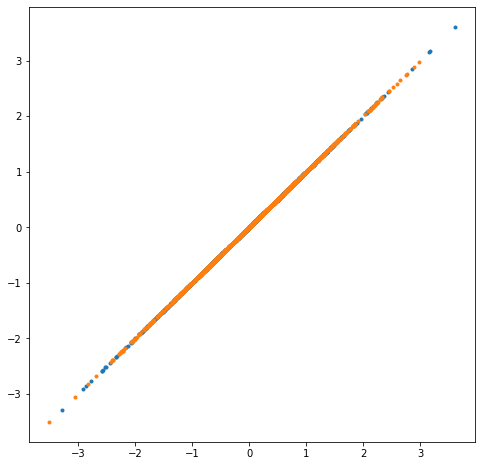

In [25]:
# визуализируем сгенерированные данные

plt.figure(figsize=(8,8))
plt.plot(regression_data,regression_data,'.' )
plt.show()

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(16,8))
plt.scatter(list(map(lambda x: x[0], regression_data)), list(map(lambda x: x[1], regression_data)), 
              c=regression_labels, cmap=colors)
plt.show()

In [26]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [27]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction

In [28]:
# Расчет дисперсии - как критерия нечистоты

def gini(labels):
    impurity = np.var(labels)     # "impurity" - "нечистота", степень неопределенности       
    return impurity

In [29]:
# float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

In [30]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества

In [31]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [32]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [33]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth, current_depth):
    if (current_depth >=max_depth):
        return Leaf(data, labels)
    quality, t, index = find_best_split(data, labels) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,max_depth, current_depth+1)
    false_branch = build_tree(false_data, false_labels,max_depth, current_depth+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [34]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [35]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [36]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [37]:
# Построим дерево по обучающей выборке

max_depth =10#параметр -  максимальной глубины дерева
# 0 - это текущая глубина дерева
my_tree = build_tree(train_data, train_labels, max_depth, 0)
print(my_tree)
display(my_tree.index, my_tree.t, my_tree.true_branch , my_tree.false_branch)

0

1.3196605134139388

In [38]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 1.3196605134139388
--> True:
  Индекс 1
  Порог 0.025975339483530497
  --> True:
    Индекс 0
    Порог 0.25745393919634973
    --> True:
      Индекс 0
      Порог -0.9793386398163768
      --> True:
        Индекс 0
        Порог -2.068894814273062
        --> True:
          Прогноз: 644.453662020209
        --> False:
          Индекс 1
          Порог -1.3562495668818044
          --> True:
            Прогноз: 217.881539434364
          --> False:
            Индекс 1
            Порог -0.8774373773110126
            --> True:
              Прогноз: -688.0752389210269
            --> False:
              Индекс 1
              Порог -0.7046996300358528
              --> True:
                Прогноз: 431.53820928142034
              --> False:
                Индекс 0
                Порог -1.302621431749788
                --> True:
                  Индекс 1
                  Порог -0.42789797573280464
                  --> True:
                    Прогноз: -49.

In [39]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[:5]

[-640.8645626805725,
 882.8475846277258,
 16.507500212166512,
 1026.750347499091,
 -238.5357578216529]

In [40]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

Accuracy = расчет *доли правильных ответов*:

$$accuracy(a,x) = \frac{1}{l} \sum^{l}_{i=1}[a(x_{i})=y_{i}].$$

In [41]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [42]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

0.0

In [43]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

0.0

In [49]:
from sklearn.tree import DecisionTreeRegressor

In [50]:
reg = DecisionTreeRegressor(random_state=0, max_depth=6)
reg.fit(train_data, train_labels)


DecisionTreeRegressor(max_depth=6, random_state=0)

In [51]:
# Точность на обучающей выборке
train_accuracy_s = accuracy_metric(train_labels,reg.predict(train_data))
train_accuracy_s,train_accuracy

(1.8571428571428572, 0.0)

In [52]:
# Точность на тестовой выборке
test_accuracy_s = accuracy_metric(test_labels,reg.predict(test_data))
test_accuracy_s,test_accuracy

(0.0, 0.0)

[Text(177.66509433962264, 201.90857142857143, 'X[0] <= 1.331\nmse = 1011706.588\nsamples = 700\nvalue = -56.312'),
 Text(94.75471698113208, 170.84571428571428, 'X[0] <= -2.924\nmse = 996283.082\nsamples = 643\nvalue = -105.182'),
 Text(88.43773584905661, 139.78285714285715, 'mse = 0.0\nsamples = 1\nvalue = 2023.604'),
 Text(101.07169811320755, 139.78285714285715, 'X[1] <= 0.028\nmse = 990765.16\nsamples = 642\nvalue = -108.498'),
 Text(50.53584905660377, 108.72, 'X[0] <= 0.26\nmse = 962623.631\nsamples = 335\nvalue = -190.579'),
 Text(25.267924528301887, 77.65714285714284, 'X[0] <= -0.969\nmse = 878151.811\nsamples = 218\nvalue = -309.851'),
 Text(12.633962264150943, 46.59428571428572, 'X[1] <= 0.012\nmse = 854056.583\nsamples = 61\nvalue = -65.484'),
 Text(6.316981132075472, 15.531428571428563, 'mse = 839886.72\nsamples = 60\nvalue = -43.905'),
 Text(18.950943396226414, 15.531428571428563, 'mse = -0.0\nsamples = 1\nvalue = -1360.208'),
 Text(37.90188679245283, 46.59428571428572, 'X[1]

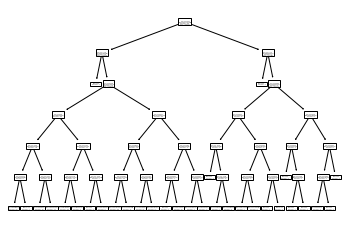

In [55]:
from sklearn import tree

tree.plot_tree(reg) 

In [56]:
dot_data = tree.export_graphviz(reg, out_file=None,feature_names=['X0'], filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

ValueError: Length of feature_names, 1 does not match number of features, 2

## Дополнительные материалы

1. [Энтропия](https://habr.com/ru/post/305794/)
2. [Энтропия - теоретическое обоснование](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)
3. [Cost-Complexity Pruning](http://mlwiki.org/index.php/Cost-Complexity_Pruning)
4. [Реализация дерева решений в функциональном стиле](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb)
5. [ООП-реализация дерева решений](https://github.com/curiousily/Machine-Learning-from-Scratch/blob/master/3_decision_trees.ipynb)
6. [Пример работы дерева решений в задаче регрессии](https://habr.com/ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii)

## Summary

* Решающее дерево - последовательное построение узлов, разбивающих множество входящих объектов согласно принципу минимизации “нечистоты” (impurity) узла
* Предикаты для разбиения в узле выбираются из всего множества признаков
* Деревья могут легко переобучиться под выборку, если не ограничивать их глубину
* Деревья очень чувствительны к небольшим изменениям в выборке (шумам)

## Домашнее задание


1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)
2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.